# Imports

In [46]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load Data

In [53]:
appl = yf.Ticker("AAPL")

In [68]:
appl_hist = appl.history(period="max")

# make pandas dataframe
apple_df = pd.DataFrame(appl_hist)

# Create Features

## Simple Moving Average SMA

In [69]:
def sma(data):
    window = [7, 14, 21]
    for i in window:
        apple_df[f"rolling_mean_{i}"] = apple_df['Close'].rolling(window=i).mean()

In [70]:
sma(apple_df)

In [71]:
apple_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,rolling_mean_7,rolling_mean_14,rolling_mean_21
Date,,,,,,,,,,
1980-12-12 00:00:00-05:00,0.099192,0.099623,0.099192,0.099192,469033600,0.0,0.0,NaN,NaN,NaN
1980-12-15 00:00:00-05:00,0.094448,0.094448,0.094017,0.094017,175884800,0.0,0.0,NaN,NaN,NaN
1980-12-16 00:00:00-05:00,0.087548,0.087548,0.087117,0.087117,105728000,0.0,0.0,NaN,NaN,NaN
1980-12-17 00:00:00-05:00,0.089273,0.089704,0.089273,0.089273,86441600,0.0,0.0,NaN,NaN,NaN
1980-12-18 00:00:00-05:00,0.091861,0.092292,0.091861,0.091861,73449600,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-03-18 00:00:00-04:00,175.570007,177.710007,173.520004,173.720001,75604200,0.0,0.0,172.454285,173.739285,176.629524
2024-03-19 00:00:00-04:00,174.339996,176.610001,173.029999,176.080002,55215200,0.0,0.0,173.218571,173.357857,176.332857
2024-03-20 00:00:00-04:00,175.720001,178.669998,175.089996,178.669998,53423100,0.0,0.0,174.064285,173.209285,176.195238


## Mony Flow Index

The Money Flow Index (MFI) is a technical oscillator that uses price and volume data for identifying overbought or oversold signals in an asset. It can also be used to spot divergences which warn of a trend change in price. The oscillator moves between 0 and 100.

https://www.investopedia.com/terms/m/mfi.asp

In [72]:
from ta.volume import money_flow_index

In [73]:
# Function to calculate Money Flow Index
# Could be extended to multiple Windos (Paramter in function)
# Uses monex_flow_index from ta library

def mony_flow_index(df):
        df['mfi'] = money_flow_index(df['High'], df['Low'], df['Close'], df['Volume'], 11, fillna=True)

mony_flow_index(apple_df)

## ... more Features to be added

## Feature Engineering

The reason behind having this step in our pipeline is that Feature engineering involves creating, transforming, or selecting the most relevant variables in your dataset to improve model performance. This process is critical because it enables the model to learn from the data more effectively, leading to better predictions and insights. Feature selection, in particular, trims down the feature set to keep only the most valuable attributes, reducing complexity, computation time, and the risk of overfitting. In essence, these techniques streamline the modelling process, making it more accurate, interpretable, and efficient, while also saving time and resources.
First, we Normalize our data set because Normalizing a dataset is crucial to ensure that all features are on a consistent scale, preventing one feature from dominating the analysis, improving model convergence, aiding in the interpretation of feature importance, making distance-based algorithms more reliable, and aligning with assumptions of regularisation techniques, all of which contribute to more effective and robust data analysis and machine learning.
Then we will just apply a small filter of variance with a threshold of 0.1 i.e. any feature which has a variance less than or equal to 0.1 will be removed from the dataset as having this low variance does not contribute much to detecting the trend in the dataset.

# Feature Selection

Now the main part is that we will calculate the importance of each feature by using Random Forest Classifier and then reduce the feature size to 81.

A rough idea of how random forest works is for each decision point (split) in each tree, the Random Forest algorithm measures the decrease in impurity(Gini impurity) resulting from the split. The impurity reduction brought about by each feature is averaged across all the trees in the forest. Features that consistently reduce impurity more effectively when used in splits are considered more important

# Labeling

In [74]:
# Function to lable the data
# if i + 11 is the max value in the window, label as BUY
# if i + 11 is the min value in the window, label as SELL
# else label as HOLD
# Idea: Buy when the stock is at its lowest in the window, sell when it is at its highest

# Source: https://medium.com/@quantclubiitkgp/stock-buy-sell-hold-prediction-using-cnn-ee7b671f4ad3

def get_labels(df, windowSize=11):
   labels = [] 
   values = []
   for i in range(len(df.Close) - windowSize): 
      mx = df.Close.iloc[i]
      mn = df.Close.iloc[i]
      mxIndex, mnIndex = i, i
      for j in range(i + 1, i + windowSize + 1): 
         if df.Close.iloc[j] > mx:
               mx = df.Close.iloc[j]
               mxIndex = j
         if df.Close.iloc[j] < mn: 
               mn = df.Close.iloc[j] 
               mnIndex = j

      if mnIndex == i + 11:
         labels.append('SELL')
         values.append(i + 11)
      elif mxIndex == i + 11:
         labels.append('BUY')
         values.append(i + 11)
      else:
         labels.append('HOLD')
         values.append(i + 11)
   
   # Append 11 times a 999 to the end of the labels list
   for i in range(11):
      labels.append(999)

   # Append the labels to the dataframe from the start
   df['Labels'] = labels

   # Replace the 999 with NaN
   df['Labels'] = df['Labels'].replace(999, np.nan)

   print('Labeling done!')

   return df


In [75]:
apple_df = get_labels(apple_df)


Labeling done!


In [76]:
apple_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,rolling_mean_7,rolling_mean_14,rolling_mean_21,mfi,Labels
Date,,,,,,,,,,,,
1980-12-12 00:00:00-05:00,0.099192,0.099623,0.099192,0.099192,469033600,0.0,0.0,NaN,NaN,NaN,50.000000,HOLD
1980-12-15 00:00:00-05:00,0.094448,0.094448,0.094017,0.094017,175884800,0.0,0.0,NaN,NaN,NaN,0.000000,HOLD
1980-12-16 00:00:00-05:00,0.087548,0.087548,0.087117,0.087117,105728000,0.0,0.0,NaN,NaN,NaN,0.000000,HOLD
1980-12-17 00:00:00-05:00,0.089273,0.089704,0.089273,0.089273,86441600,0.0,0.0,NaN,NaN,NaN,23.061096,HOLD
1980-12-18 00:00:00-05:00,0.091861,0.092292,0.091861,0.091861,73449600,0.0,0.0,NaN,NaN,NaN,35.970823,HOLD
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-18 00:00:00-04:00,175.570007,177.710007,173.520004,173.720001,75604200,0.0,0.0,172.454285,173.739285,176.629524,34.261474,NaN
2024-03-19 00:00:00-04:00,174.339996,176.610001,173.029999,176.080002,55215200,0.0,0.0,173.218571,173.357857,176.332857,42.344872,NaN
2024-03-20 00:00:00-04:00,175.720001,178.669998,175.089996,178.669998,53423100,0.0,0.0,174.064285,173.209285,176.195238,51.657585,NaN


<Axes: >

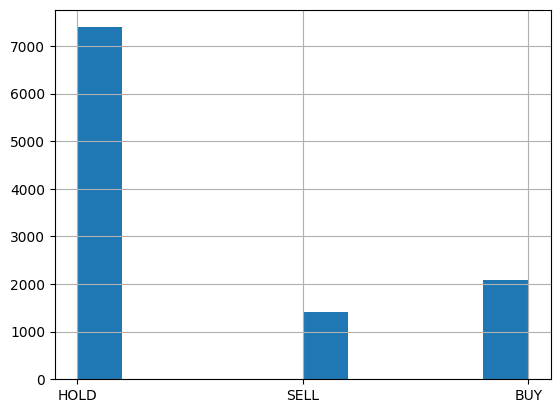

In [77]:
# plot a histogramm of the labels
apple_df['Labels'].hist()


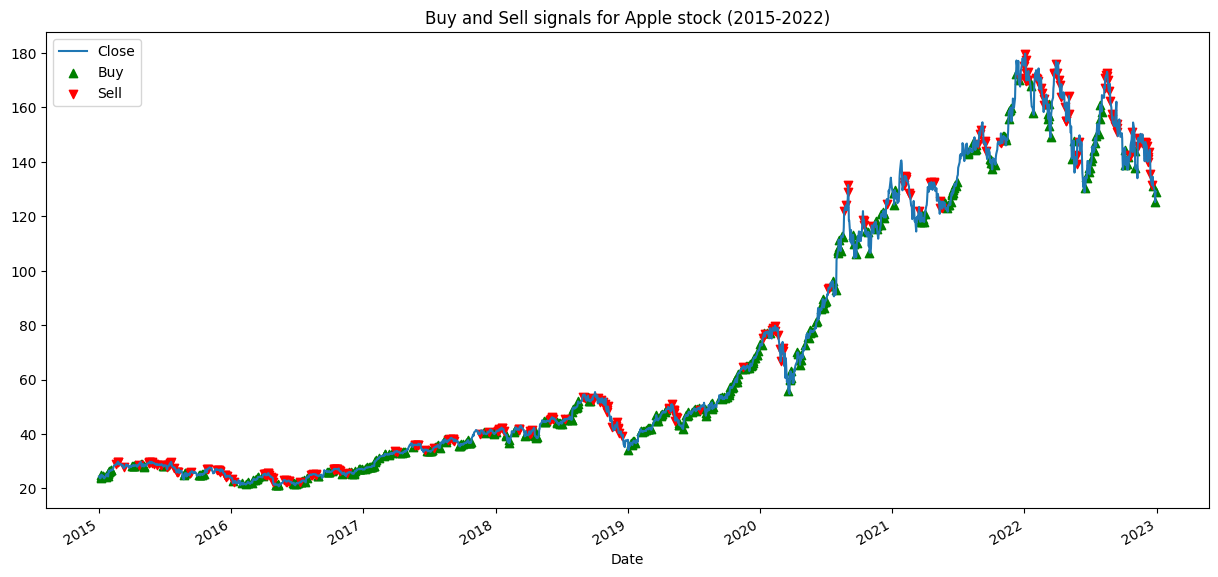

In [78]:
plt.figure(figsize=(15, 7))

# add buy and sell signals
# buy = green, sell = red
buy = apple_df[(apple_df['Labels'] == 'BUY') & (apple_df.index >= '2015-01-01') & (apple_df.index <= '2022-12-31')]
sell = apple_df[(apple_df['Labels'] == 'SELL') & (apple_df.index >= '2015-01-01') & (apple_df.index <= '2022-12-31')]
apple_df['Close']['2015':'2022'].plot()
plt.scatter(buy.index, buy['Close'], color='g', marker='^', alpha=1)
plt.scatter(sell.index, sell['Close'], color='r', marker='v', alpha=1)
plt.title('Buy and Sell signals for Apple stock (2015-2022)')
plt.legend(['Close', 'Buy', 'Sell'])
plt.show()



## Feature Importamce in Prediction

Used mutual info classification for creating heat map for our image. Basically it tells us which part of the image is most useful to the model (will explain this part more in further ). (https://medium.com/@quantclubiitkgp/stock-buy-sell-hold-prediction-using-cnn-ee7b671f4ad3)

> keine Ahnung was er damit meint und warum er das macht??!

## Image Creation

## CNN

## Trading Bot Implementation